# 清洗与分析数据

In [1]:
import pandas as pd
import numpy as np
import json
import requests
import tweepy
import matplotlib.pyplot as plt
import re

### 获取图像的预测数据
对出现在每个推特中狗的品种（或其他物体、动物等）进行预测的结果

In [2]:
image_url = 'https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv'
response = requests.get(image_url)
with open('image-predictions.tsv','w') as image_file:
    image_file.write(response.text)

In [3]:
# 解析 tweet-json.txt
tweet_json_info = []
with open('tweet-json.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
    for line in lines:
        line = json.loads(line)
        try:
            expanded_url = line["entities"]["media"][0]["expanded_url"]
        except Exception as err:
            expanded_url = np.NaN
        try:
            media_url_https = line["entities"]["media"][0]["media_url_https"]
        except Exception as err:
            media_url_https = np.NaN
        tweet_json_info.append({"tweet_id": line["id"], 
                                "retweet_count": line["retweet_count"], 
                                "favorite_count": line["favorite_count"],
                                "expanded_urls": expanded_url,
                                "jpg_url": media_url_https
                               })

df_tweet_retweet_favorite = pd.DataFrame(data=tweet_json_info, columns=["tweet_id", 
                                                                        "retweet_count", 
                                                                        "favorite_count",
                                                                        "expanded_urls",
                                                                        "jpg_url"
                                                                       ])

In [4]:
# 存储 tweet 转发、点赞信息
df_tweet_retweet_favorite.to_csv('tweet-retweet-favorite.csv', index=False)

### 文件读取

In [5]:
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_tweet_retweet_favorite = pd.read_csv('tweet-retweet-favorite.csv')
df_image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

In [6]:
df_twitter_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [7]:
df_tweet_retweet_favorite.head(3)

,tweet_id,retweet_count,favorite_count,expanded_urls,jpg_url
0,892420643555336193,8842,39492,https://twitter.com/dog_rates/status/892420643...,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,6480,33786,https://twitter.com/dog_rates/status/892177421...,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,4301,25445,https://twitter.com/dog_rates/status/891815181...,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg


In [8]:
df_image_predictions.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


### `df_twitter_archive`  表

- tweet_id: 推文id
- in_reply_to_status_id: 可空。 如果表示的Tweet是回复，则此字段将包含原始推文ID的整数表示。例: "in_reply_to_status_id":1051222721923756032
- in_reply_to_user_id:   可空。 如果表示的Tweet是回复，则此字段将包含原始Tweet的作者ID的整数表示。 这不一定总是Tweet中直接提到的用户。 例："in_reply_to_user_id":6253282
- timestamp: 创建时间
- source:  用于发布推文的实用程序，作为HTML格式的字符串。 来自Twitter网站的推文具有网络的来源价值。
- text: 推文
- retweeted_status_id: 用户可以通过转发放大其他用户创作的推文的广播。 转发可以通过retweeted_status属性的存在与典型的推文区分开来。 此属性包含转发的原始推文的表示形式。 
- retweeted_status_user_id: 此属性包含转发的原始用户的表示形式。
- retweeted_status_timestamp', 
- expanded_urls:  display_url的扩展版本。 指向媒体显示页面的链接
- rating_numerator: 评级分子
- rating_denominator: 评级分母
- name: dog名字
- doggo: 类别
- floofer: 类别
- pupper: 类别
- puppo: 类别

### `image-predictions` 表
以该表格中的最后一行数据来理解各列数据：

- tweet_id 是推特链接的最后一部分，位于 "status/" 后面 → https://twitter.com/dog_rates/status/889531135344209921
- jpg_url 是预测的图像资源链接
- img_num 最可信的预测结果对应的图像编号 → 1 推特中的第一张图片
- p1 是算法对推特中图片的一号预测 → 金毛犬
- p1_conf 是算法的一号预测的可信度 → 95%
- p1_dog 是一号预测该图片是否属于“狗”（有可能是其他物种，比如熊、马等） → True 真
- p2 是算法对推特中图片预测的第二种可能性 → 拉布拉多犬
- p2_conf 是算法的二号预测的可信度 → 1%
- p2_dog 是二号预测该图片是否属于“狗” → True 真
- 以此类推...

### `tweet-retweet-favorite` 表
- tweet_id: 推文id
- retweet_count: 转发数
- favorite_count: 点赞数

# 评估

## 数据问题
### 质量
#### `df_twitter_archive` table
- retweeted_status_timestamp 列类型不对 应为datetime类型
- timestamp 列类型不对，应为datetime类型
- in_reply_to_status_id、in_reply_to_user_id 有回复的推文 (78条)
- retweeted_status_id、retweeted_status_user_id 有转发的推文 (181条) 
- name 有745个None, 55个a 值 (从text截取名字有误)
- source 列包含html信息
- rating_numerator 列值错误 （索引号: 695 、340、763、1712、1689、45...）
- rating_denominator 列有不等于10的值
- expanded_urls 有缺失值
- doggo、floofer、pupper、puppo 列，有些推文中有明确的stage，对应stage值缺失

### 清洁度
- `df_twitter_archive` doggo、floofer、pupper、puppo 列应该合成一列
- `df_retweet_favorite` 应该是`df_twitter_archive`的一部分


In [9]:
# 排查列的类型是否有问题
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [10]:
# 查看source列信息
df_twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [11]:
# 查看tweet_id是否有重复列
df_twitter_archive[df_twitter_archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [12]:
# 查看是否有转发的推文
df_twitter_archive[~((df_twitter_archive.in_reply_to_status_id.isnull()) | (df_twitter_archive.in_reply_to_user_id.isnull()))].shape

(78, 17)

In [13]:
# 查看name、doggo、floofer、pupper、puppo列信息
cols = ['doggo','floofer', 'pupper','puppo', 'name']
for col in cols:
    print('*' * 10, col , '*' * 10)
    print(df_twitter_archive[col].value_counts().head(10))

********** doggo **********
None     2259
doggo      97
Name: doggo, dtype: int64
********** floofer **********
None       2346
floofer      10
Name: floofer, dtype: int64
********** pupper **********
None      2099
pupper     257
Name: pupper, dtype: int64
********** puppo **********
None     2326
puppo      30
Name: puppo, dtype: int64
********** name **********
None       745
a           55
Charlie     12
Cooper      11
Lucy        11
Oliver      11
Lola        10
Penny       10
Tucker      10
Bo           9
Name: name, dtype: int64


In [14]:
# 查看最近的时间是否大于2017-08-01
df_twitter_archive.timestamp.sort_values(ascending=False).head()

0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
2    2017-07-31 00:18:03 +0000
3    2017-07-30 15:58:51 +0000
4    2017-07-29 16:00:24 +0000
Name: timestamp, dtype: object

In [15]:
# 检查 rating_numerator 的正确与否
# pattern = re.compile(r'[0-9]?\.?\d{1,10}\/\d{1,10}\s?')
pattern = re.compile(r'\d{0,10}\.?\d{1,10}\/\d{1,10}\s?')
wrong_numerator = []

def getWrongRateNumerator(df):
    for idx, row in df.iterrows():
        rates = re.findall(pattern, df.loc[idx,:].text)
        try:
            # multi num/num  select first combination
            rate = rates[0].strip().split('/')[0]
            # Handling the beginning character: point ,eg .10
            if rate.startswith('.'):
                rate = rate[1:]
            if float(rate) != float(row['rating_numerator']):
                wrong_numerator.append({"index": idx, 
                                        "text_rates": rates, 
                                        "current_rating_numerator": row['rating_numerator']
                                       })
        except IndexError as err:
            wrong_numerator.append({"index": idx, 
                                    "text_rates": rates, 
                                    "current_rating_numerator": row['rating_numerator']
                                   })

# 传入df_twitter_archive dataframe
getWrongRateNumerator(df_twitter_archive)
# 查看结果
print(wrong_numerator)

[{'index': 45, 'text_rates': ['13.5/10 '], 'current_rating_numerator': 5}, {'index': 340, 'text_rates': ['9.75/10 '], 'current_rating_numerator': 75}, {'index': 695, 'text_rates': ['9.75/10 '], 'current_rating_numerator': 75}, {'index': 763, 'text_rates': ['11.27/10 '], 'current_rating_numerator': 27}, {'index': 1689, 'text_rates': ['9.5/10'], 'current_rating_numerator': 5}, {'index': 1712, 'text_rates': ['11.26/10 '], 'current_rating_numerator': 26}]


In [16]:
df_wrong_numerator = pd.DataFrame(data=wrong_numerator, columns=["index", "text_rates", "current_rating_numerator"])
df_wrong_numerator

,index,text_rates,current_rating_numerator
0,45,[13.5/10 ],5
1,340,[9.75/10 ],75
2,695,[9.75/10 ],75
3,763,[11.27/10 ],27
4,1689,[9.5/10],5
5,1712,[11.26/10 ],26


In [17]:
# 查看 错误的 rating_numerator值: index, text , rating_numerator, rating_denominator
for item in wrong_numerator:
    print("{:<4} {:<20s} {:>4} {:>4}".format(item["index"], item["text_rates"][0],
                                              df_twitter_archive.loc[item["index"],:].rating_numerator,
                                              df_twitter_archive.loc[item["index"],:].rating_denominator))

45   13.5/10                 5   10
340  9.75/10                75   10
695  9.75/10                75   10
763  11.27/10               27   10
1689 9.5/10                  5   10
1712 11.26/10               26   10


In [18]:
# 检查分母不等10的数据样本
pd.set_option('max_colwidth',200)
df_twitter_archive.query('rating_denominator != 10')[['text','rating_numerator','rating_denominator']]


,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [19]:
# 确认 tweet_id的包含关系, 确认 df_image_predictions 和 df_tweet_retweet_favorite 的 tweet_id都包含在df_twitter_archive中
print(df_image_predictions.loc[df_image_predictions.tweet_id.isin(df_twitter_archive.tweet_id), ['tweet_id']].shape)
print(df_tweet_retweet_favorite.loc[df_tweet_retweet_favorite.tweet_id.isin(df_twitter_archive.tweet_id), ['tweet_id']].shape)

(2075, 1)
(2352, 1)


In [20]:
df_image_predictions.shape

(2075, 12)

In [21]:
df_tweet_retweet_favorite.shape

(2352, 5)

In [22]:
# 查看rating是否有空值
df_twitter_archive[df_twitter_archive.rating_numerator.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [23]:
df_twitter_archive[df_twitter_archive.rating_denominator.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


# 清理

In [24]:
twitter_archive_clean = df_twitter_archive.copy()
tweet_retweet_favorite_clean = df_tweet_retweet_favorite.copy()
image_predictions_clean = df_image_predictions.copy()

### 数据质量处理

####  `retweeted_status_timestamp` 和 `timestamp`  类型

##### 定义
*`retweeted_status_timestamp` 使用 pandas.to_datetime修改数据类型*

*`timestamp` 使用 pandas.to_datetime修改数据类型*

##### 代码

In [25]:
twitter_archive_clean.retweeted_status_timestamp = pd.to_datetime(twitter_archive_clean.retweeted_status_timestamp)
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive_clean.timestamp)

##### 测试

In [26]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns, UTC]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null datetime64[ns, UTC]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes

####  in_reply_to_status_id、in_reply_to_user_id 查看有重复的推文 (78条)

##### 定义
*删除 `in_reply_to_status_id、in_reply_to_user_id` 有值得行。*

##### 代码

In [27]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.isnull()]

##### 测试

In [28]:
twitter_archive_clean[~(twitter_archive_clean.in_reply_to_status_id.isnull())].shape

(0, 17)

#### retweeted_status_id、retweeted_status_user_id 有转发的推文 (181条)

#### 定义
*删除 retweeted_status_id、retweeted_status_user_id  有值得记录*

#### 代码

In [29]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]

#### 测试

In [30]:
twitter_archive_clean[~(twitter_archive_clean.retweeted_status_id.isnull())].shape

(0, 17)

#### source 列包含html信息

##### 定义
*使用正则表达式: ，匹配删除无用的html字符*

##### 代码

In [31]:
twitter_archive_clean.source = twitter_archive_clean.source.str.extract('>(.+?)<',expand = True)
#for idx, row in twitter_archive_clean[['source']].iterrows():
#    data = re.findall(r'>(.+?)<', row['source'])
#    twitter_archive_clean.loc[idx,'source'] = data[0]

##### 测试

In [32]:
twitter_archive_clean.source.value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

#### rating_denominator 列有不等于10的值

##### 定义
**出去rating_denominator 不等于10的记录，一部分修改为正确的值，删除一部分的错误样本记录**

##### 代码

In [ ]:
# 处理代码
# index: 1068, 1065, 1202, 1662, 2335 的样本 rating_numerator, rating_denominator 值错误
for idx, row in twitter_archive_clean.query('rating_denominator != 10')[['text','rating_numerator', 'rating_denominator']].iterrows():
    #print(idx,row)
    #print(row.text.extract('\d{0,10}\.?\d{1,10}\/\d{1,10}\s?'))
    data = re.findall(pattern, row.text)
    print(data)
    if len(data) > 1:
        numerator = data[1].strip().split('/')[0]
        denominator = data[1].strip().split('/')[1]
        if denominator == 10:
            twitter_archive_clean.loc[idx, 'rating_denominator'] = numerator
            twitter_archive_clean.loc[idx, 'rating_denominator'] = denominator
# 修正后，删除剩余分母不等于10的记录
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.rating_denominator == 10]

##### 测试

In [ ]:
twitter_archive_clean.query('rating_denominator != 10')[['text','rating_numerator', 'rating_denominator']]

#### rating_numerator 列值错误 （索引号: 695 、340、763、1712、1689、45）

##### 定义
*取出正确的值，datafarame.loc[index, 'column'] = value 修改为正确的值*

##### 代码

In [33]:
wrong_numerator = []
getWrongRateNumerator(twitter_archive_clean)

In [34]:
wrong_numerator

[{'index': 45, 'text_rates': ['13.5/10 '], 'current_rating_numerator': 5},
 {'index': 695, 'text_rates': ['9.75/10 '], 'current_rating_numerator': 75},
 {'index': 763, 'text_rates': ['11.27/10 '], 'current_rating_numerator': 27},
 {'index': 1712, 'text_rates': ['11.26/10 '], 'current_rating_numerator': 26}]

In [35]:
for item in wrong_numerator:
    twitter_archive_clean.loc[item["index"], "rating_numerator"] = item["text_rates"][0].split('/')[0]

##### 测试

In [36]:
for item in wrong_numerator:
    print(twitter_archive_clean.loc[item["index"],"rating_numerator"])

13.5
9.75
11.27
11.26


#### name 有745个None, 55个a 值 (从text截取名字有误)

##### 定义
*使用正则取出name，更正错误的name值*

##### 代码

In [39]:
# 推文中包含 "named" 取 named 后一个单词 作为 name
named_pattern = re.compile(r'named\s[a-zA-z0-9]+.', re.UNICODE)

for idx, row in twitter_archive_clean.iterrows():
    named = re.findall(named_pattern, row['text'])
    if len(named) > 0:
        twitter_archive_clean.loc[idx, 'name'] = named[0].split()[-1][:-1]


In [40]:
# 现有的名字
names_list = list(twitter_archive_clean.name.unique())

for name in ['a','an','the','None','O']:
    names_list.remove(name)

# 依据现有的 name 填充 name in ['a', 'an', 'None'] 的 name 
for idx, row in twitter_archive_clean.iterrows():
    for name in names_list:
        if name[0].isupper() and len(name) > 1 and  name in row['text'].split() and row['name'] in ['O', 'a','an','the','None']:
            twitter_archive_clean.loc[idx,'name'] = name
            # print("{0}: curname: {1}: names: {2} --> {3} ".format(idx, row['name'], name, row['text']))
            break


In [41]:
# 当 name 为小写或者 name 为 None 的时候，将这些数据的 name 修改为 np.nan
mask = (twitter_archive_clean.name.str.islower())|(twitter_archive_clean.name == 'None')
twitter_archive_clean.loc[mask, 'name'] = np.nan

##### 测试

In [42]:
twitter_archive_clean.name.value_counts().head(10)

Lucy       11
Cooper     11
Charlie    11
Oliver     10
Tucker      9
Penny       9
Winston     8
Lola        8
Toby        8
Happy       8
Name: name, dtype: int64

#### expanded_urls 有缺失值

##### 定义
*`expanded_urls`删除NaN的记录*

##### 代码


In [43]:
twitter_archive_clean = twitter_archive_clean[~(twitter_archive_clean.expanded_urls.isnull())]

##### 测试

In [44]:
twitter_archive_clean.expanded_urls.isnull().sum()

0

### 数据清洁度清理

#### doggo、floofer、pupper、puppo 列，有些推文中有明确的stage，对应stage值缺失
#### df_twitter_archive doggo、floofer、pupper、puppo 列应该合成一列

##### 定义
*1. 使用正则re.findall(r'doggo|floofer|pupper|puppo', df.loc[idx,:].text.lower())匹配更新对应列值*

*2. 由于4列None值比较多，用python变成的方法合并成一列`stage`*

#####  代码

In [45]:
# 处理 doggo、floofer、pupper、puppo
# doggo 大些的狗
# pupper 小狗
# puppo 少年狗
# floofer 多毛狗
def getDogStage(df):
    for idx, row in df.iterrows():
        #print(idx, row)
        result = re.findall(r'doggo|floofer|pupper|puppo', df.loc[idx,:].text.lower())
        try:
            if len(result) > 0:
                df.loc[idx, result[0]] = result[0]
                # print("{} {} {}".format(result, idx, df.loc[idx,result[0]]))
        except IndexError as err:
            print(err)

getDogStage(twitter_archive_clean)

# 由于4个列None多，meta不适合，使用循环的方式把有值得记录 补录到 `stage` 列
twitter_archive_clean['stage'] = np.NaN

for idx, row in twitter_archive_clean.iterrows():
    for col in ['doggo', 'floofer', 'pupper', 'puppo']:
        if row[col] != 'None':
            twitter_archive_clean.loc[idx, 'stage'] = col
            break


##### 测试

In [46]:
twitter_archive_clean[~(twitter_archive_clean.stage.isnull())].shape

(366, 18)

In [47]:
twitter_archive_clean.shape

(2077, 18)

#### retweet_favorite_clean( 转发、点赞) 、image_predictions_clean.p1 应该是twitter_archive_clean的一部分

#####  定义
*使用pandas.merge融合两个dataframe*

##### 代码

In [48]:
twitter_archive_clean = pd.merge(twitter_archive_clean, tweet_retweet_favorite_clean, on='tweet_id', how='left')

In [49]:
twitter_archive_clean.drop(['expanded_urls_y', 'jpg_url', 'doggo', 'floofer', 'pupper', 'puppo'],axis=1, inplace=True)

In [50]:
twitter_archive_clean = twitter_archive_clean.rename(columns={"expanded_urls_x": "expanded_urls"})

In [51]:
image_temp = image_predictions_clean[['tweet_id', 'p1']]
# merge 选择 inner方式，这样可以删除原始推文中没有图片的推文
twitter_archive_clean = pd.merge(twitter_archive_clean, image_temp, on='tweet_id', how='inner')
twitter_archive_clean.rename(columns={'p1': 'dog_type'},inplace=True)

### 存储清理后的主数据集

In [52]:
twitter_archive_clean.to_csv('twitter-archive-master.csv', index=False)

#### 测试

In [53]:
twitter_archive_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,dog_type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN,8842,39492,orange
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN,6480,33786,Chihuahua


In [54]:
twitter_archive_clean.shape

(1954, 17)

# 可视化分析

### 见解
- 推文主要来源
- 狗狗类型占比
- 狗狗类型 与 点赞、转发、评分 均值的关系


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['font.size'] = 12.0

### 推文来源占比

([<matplotlib.patches.Wedge at 0x122c3f5d0>,
 [Text(-1.0978382816455385, 0.06892827687946032, 'Twitter for iPhone'),
  Text(1.0964476342626728, -0.08833224394176906, 'Twitter Web Client'),
  Text(1.0998279798491513, -0.019452885157102116, 'TweetDeck')],
 [Text(-0.5988208808975664, 0.037597241934251076, '98.0%'),
  Text(0.5980623459614578, -0.04818122396823766, '1.4%'),
  Text(0.5999061708268096, -0.010610664631146608, '0.6%')])

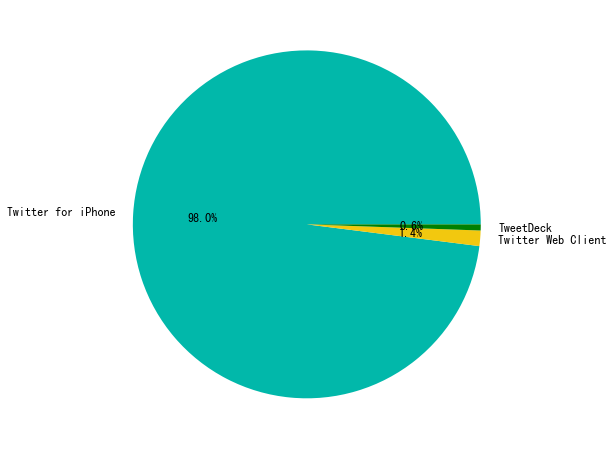

In [56]:
labels = twitter_archive_clean.source.value_counts().index
sizes = twitter_archive_clean.source.value_counts().values
fig = plt.figure(1, figsize=(8,8))
ax = fig.add_subplot(111)
colors = ('#01B8AA', '#F2C80F', 'g', 'r', 'c', 'm', 'y', 'burlywood', 'w')
ax.pie(sizes,colors=colors ,labels=labels, autopct='%1.1f%%')
#ax.title('Twitter sending platform',fontsize=15)


### 按dog_type分类统计 和 点赞、转发、评分均值的关系

In [57]:
twitter_archive_clean.rating_numerator = twitter_archive_clean.rating_numerator.astype('float64')

#### 构造DataFrame

In [58]:
dog_type_gb = twitter_archive_clean.groupby(['dog_type'])
dog_type_counts = dog_type_gb.size()[dog_type_gb.size()>10].to_frame(name='counts')
dog_type_counts = dog_type_counts \
.join(dog_type_gb.agg({'retweet_count': 'median'}).rename(columns={'retweet_count': 'retweet_count_median'})) \
.join(dog_type_gb.agg({'favorite_count': 'median'}).rename(columns={'favorite_count': 'favorite_count_median'})) \
.join(dog_type_gb.agg({'rating_numerator': 'median'}).rename(columns={'rating_numerator': 'rating_numerator_median'})) \
.join(dog_type_gb.agg({'retweet_count': 'mean'}).rename(columns={'retweet_count': 'retweet_count_mean'})) \
.join(dog_type_gb.agg({'favorite_count': 'mean'}).rename(columns={'favorite_count': 'favorite_count_mean'})) \
.join(dog_type_gb.agg({'rating_numerator': 'mean'}).rename(columns={'rating_numerator': 'rating_numerator_mean'}))

In [59]:
dog_type_counts = dog_type_counts.reset_index()
dog_type_counts = dog_type_counts.sort_values(by='counts', ascending=False)
dog_type_counts

,dog_type,counts,retweet_count_median,favorite_count_median,rating_numerator_median,retweet_count_mean,favorite_count_mean,rating_numerator_mean
30,golden_retriever,134,2296.0,8253.0,12.00,3632.708955,12369.738806,11.630597
11,Labrador_retriever,91,1824.0,5962.0,11.00,3929.164835,12094.659341,11.131868
16,Pembroke,88,1964.0,6521.0,12.00,3170.170455,11270.022727,11.443182
5,Chihuahua,78,934.5,2935.0,11.00,2800.500000,8603.653846,10.692308
35,pug,54,985.0,2624.0,10.00,1827.314815,5909.240741,10.240741
27,chow,41,2213.0,6837.0,12.00,2900.634146,10102.195122,11.609756
19,Samoyed,40,2679.0,7438.0,12.00,4597.425000,13533.625000,11.700000
17,Pomeranian,38,1138.0,3053.0,11.00,2863.105263,8103.210526,11.151316
38,toy_poodle,37,1146.0,4128.0,11.00,2499.351351,6746.540541,11.054054
33,malamute,29,2177.0,6984.0,11.00,2530.241379,8559.206897,10.896552


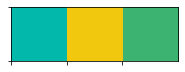

In [60]:
color_board = ['#01B8AA', '#F2C80F','#3CB371']
sns.palplot(sns.color_palette(color_board))

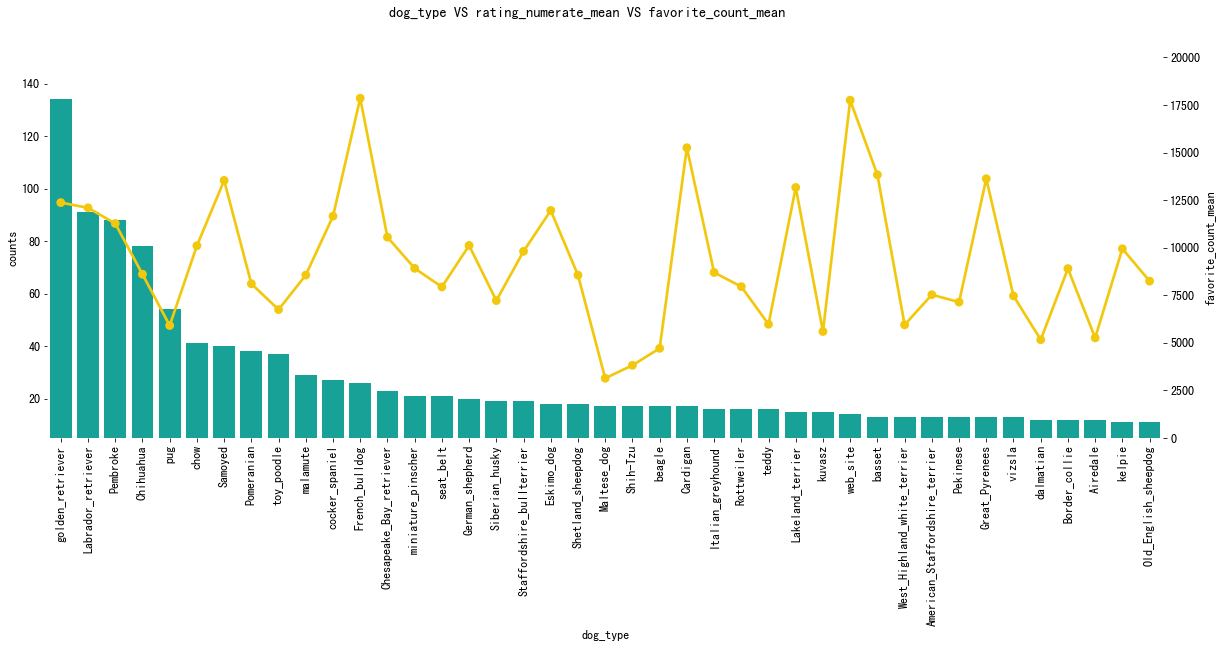

In [61]:
# 定义画板
fig, ax = plt.subplots(figsize=(20, 7))

# 先画bar图
bar_graph = sns.barplot(data = dog_type_counts, 
                       x = 'dog_type', y = 'counts',
                       color=color_board[0],
                       ax = ax)

# ax2 = ax.twinx()

# bar_graph = sns.pointplot(data = dog_type_counts, 
#                        x = 'dog_type', y = 'rating_numerator_mean',
#                        color=color_board[2],
#                        ax = ax2)

plt.xticks(rotation = 90)

# 线图
ax3 = ax.twinx() # 定义自己的x轴
line_graph = sns.pointplot(data=dog_type_counts,
                          x = 'dog_type', y = 'favorite_count_mean',
                          color=color_board[1],
                          ax = ax3)

# 设置y轴刻度
ax.set_ylim(bottom = 5, top=150, auto=True)
# ax2.set_ylim(bottom = 5, top = 15, auto=True)
ax3.set_ylim(bottom = 0, top = 20000, auto=True)

plt.suptitle('dog_type VS rating_numerate_mean VS favorite_count_mean', fontweight = 'bold')
# 清除边框
sns.despine(left = True, bottom=True)

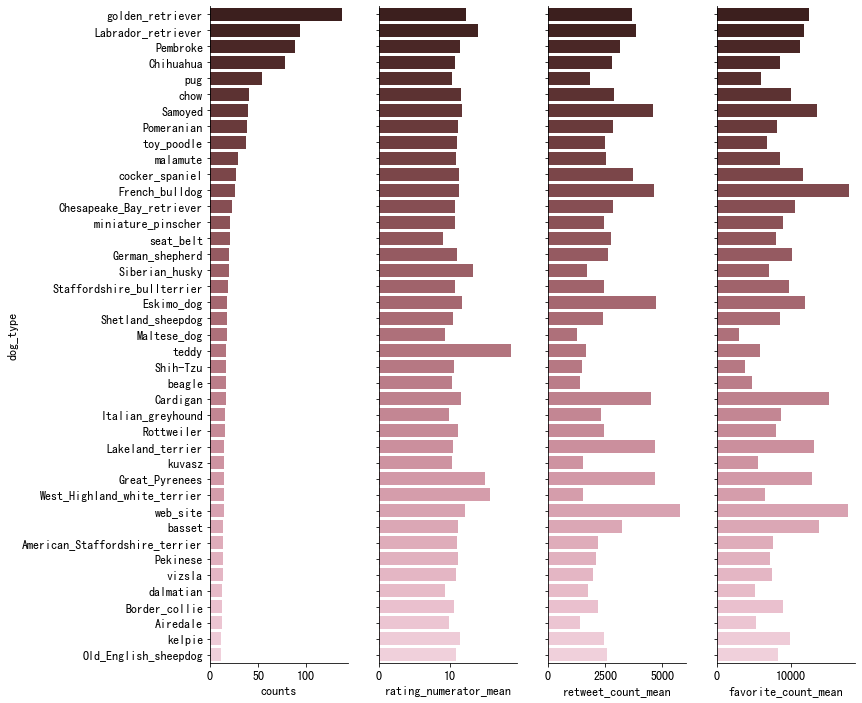

In [59]:
g = sns.PairGrid(data = dog_type_counts.sort_values(by='counts', ascending=False), y_vars = 'dog_type',  x_vars = ['counts', 'rating_numerator_mean', 'retweet_count_mean', 'favorite_count_mean'] , height = 10, aspect = 0.25)
g.map(sns.barplot, orient = 'h',
     palette = "ch:s=1, r=-.1, h=1_r")

## 结论

1. 最常见的狗狗：golden_retriever、Labrador_retriever、Pembroke、Chihuahua 人们的评分、点赞、转发都偏高
2. 人们最喜欢的狗狗：French_bulldog、Gardigan, 评分相对也高
3. 评分最高的是teddy, 但人们不喜欢点赞、转发和teddy相关的推文